In [14]:
import torch
import torchvision
from torch import nn
from d2l import torch as d2l
from PIL import Image

In [44]:
all_images = torchvision.datasets.CIFAR10(train=True,root="../data",download=True)

In [45]:
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
])
test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [46]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size,
                                             shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader

In [48]:
def train_batch_ch13(net, X, y, loss, trainer, devices):
    if isinstance(X, list):
        # 微调BERT中所需
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

In [55]:
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices=d2l.try_all_gpus()):
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch',xlim=[1, num_epochs],ylim=[0,1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net, features,labels, loss,trainer,devices)
            metric.add(l,acc,labels.shape[0], labels.numel())
            timer.stop()
            
            if (i+1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch+(i+1)/num_batches,
                             (metric[0]/metric[2], metric[1]/metric[3], None))
        
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None,None, test_acc))
    
    print(f'loss {metric[0]/metric[2]:.3f}, train acc '
          f'{metric[1]/metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2]*num_epochs / timer.sum() :.1f} example/sec on '
          f'{str(devices)}')

In [53]:
batch_size, devices, net = 256, d2l.try_all_gpus(), torchvision.models.resnet18(10,3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_adta_aug(train_augs, test_augs, net, lr=1e-3):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction='none')
    trainer = torch.optim.Adam(net.parameters(), lr)
    train_ch13(net, train_iter, test_iter,loss, trainer, 10, devices)

/root/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' and 'progress' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/root/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loss 0.209, train acc 0.928, test acc 0.766
17065.2 example/sec on [device(type='cuda', index=0)]


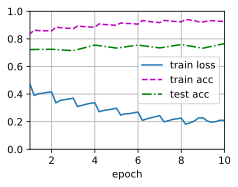

In [56]:
train_with_adta_aug(train_augs, test_augs, net)

loss 0.046, train acc 0.985, test acc 0.763
15745.5 example/sec on [device(type='cuda', index=0)]


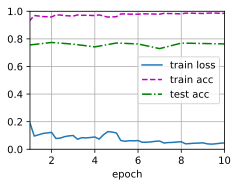

In [58]:
train_with_adta_aug(test_augs,test_augs, net)